# House Prices - Advanced Regression Techniques

## Introduction

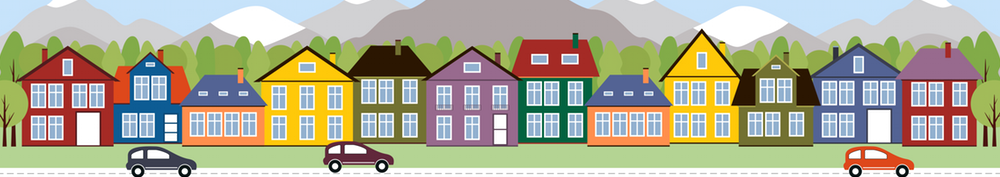

Bạn là một nhà môi giới bất động sản. Để có thể làm tốt công việc của mình, bạn yêu cầu khách hàng mua nhà mô tả ngôi nhà mơ ước của họ, và những tiêu chí họ nghĩ đến đầu tiên không phải căn nhà có tầng hầm hoặc vị trí nhà gần đường sắt. 

Với 79 biến giải thích, (gần như) mọi khía cạnh của nhà ở ở Ames, Iowa (2 thành phố của Mỹ). Cuộc thi này thách thức bạn dự đoán giá cuối cùng của mỗi ngôi nhà.

## Level 5 : 

- Thêm thắt, chỉnh sửa Level 4

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
df_train = pd.read_csv('C:/Users/84909/Linear Regression/Datasets/train.csv')

## Descriptive statistics

In [5]:
# Kiểm tra có cột nào bị trùng lặp hay không
sum(df_train.duplicated())

0

In [6]:
sum(df_train['Id'].duplicated())

0

In [7]:
# df_train.head()

Ta sẽ tiến hành nhìn sơ qua dữ liệu và loại bỏ ngay các features không cần thiết.

In [8]:
df_train.drop(columns = 'Id', inplace = True)

### Tìm hiểu biến mục tiêu

In [20]:
# df_train['SalePrice'].describe()

Ta có thể nhận xét một số thứ như sau:

- Min: Không có giá trị âm.

- Max: Giá trị max cách khá xa IQR3 (75%) nên ta nghi ngờ sẽ có outlier trong cột này.

Để làm rõ điều này, ta có thể vẽ một số biểu đồ để lấy thêm thông tin

In [23]:
# plt.figure(figsize=(15, 5))
# sns.set(style="white")
# sns.boxplot(data = df_train, x = 'SalePrice')
# plt.title('House\'s Sale Price')
# plt.yticks([])
# sns.despine(top=True, right=True)
# #plt.show()

Biểu đồ boxplot cho chúng ta thấy được bức tranh tổng quan về các chỉ số như:

- Trung bình

- Độ lệch : Phần bên trên rộng hơn nên có thể nói cột SalePrice bị lệch phải.

- Outlier : Có khá nhiều outlier, hầu hết đều lớn hơn hẳn so với mức trung bình.

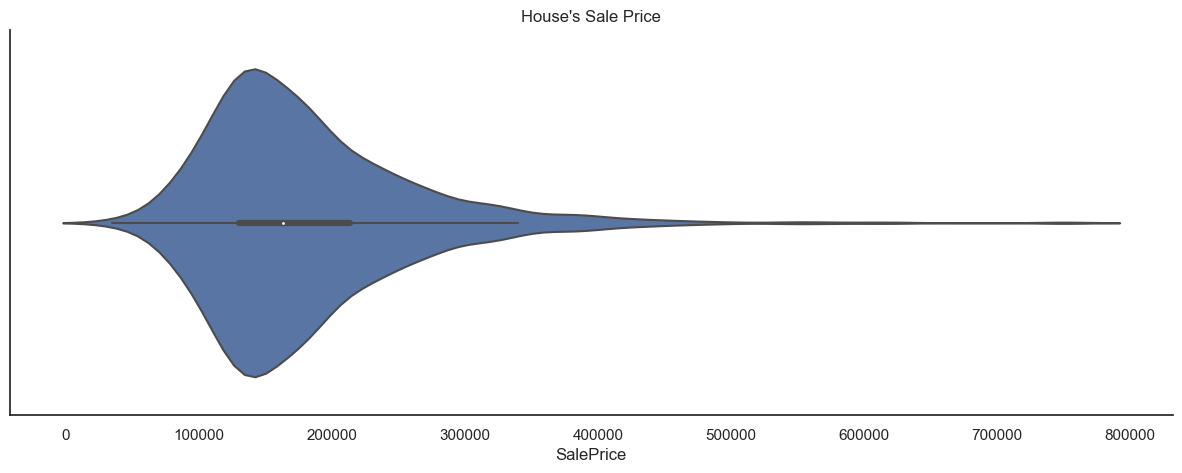

In [234]:
plt.figure(figsize=(15, 5))
sns.set(style="white")
sns.violinplot(data = df_train, x = 'SalePrice')
plt.title('House\'s Sale Price')
plt.yticks([])
sns.despine(top=True, right=True)
plt.show()

Có thể sử dụng biểu đồ này thay cho Histogram để thấy được phân phối của dữ liệu. (Ngoài ra sẽ thích hợp hơn khi kết hợp với các cột categories khác)

Ví dụ như:

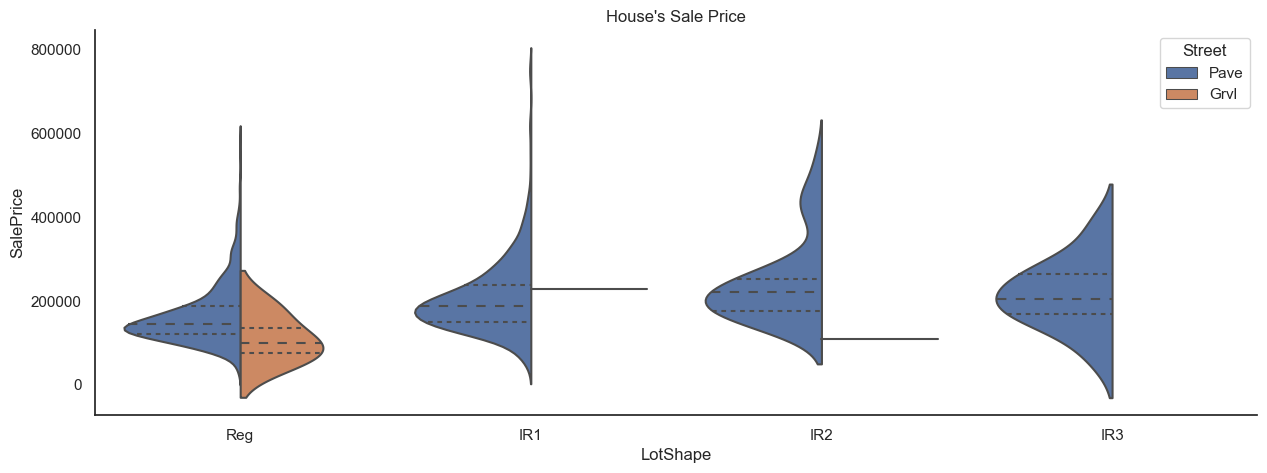

In [235]:
plt.figure(figsize=(15, 5))
sns.set(style="white")
sns.violinplot(data = df_train, x = 'LotShape', y = 'SalePrice', 
               hue = 'Street', split=True, inner="quart")
plt.title('House\'s Sale Price')
sns.despine(top=True, right=True)
plt.show()

Ta có thể nhận xét được:

- Đường trải sỏi (Grvl) phần lớn chỉ có ở những khu đất có hình dạng đều đặn (Reg), có rất ít ở những lô đất không đều (IR1 và IR2) và không có nếu lô đất rất không đều (IR3)

- Giá của những căn nhà có đường trải sỏi sẽ thấp và ổn định hơn so với đường trải nhựa qua hình dạng phân phối chuẩn hơn và không có outlier.

> Kiểu như nếu bạn là khách hàng, không quá quan trọng đường trải nhựa hay không thì giá nên cân nhắc mua những căn nhà có đường trải sỏi để thấp hơn. Hoặc là 1 bài toán trade-off giữa tiền mua căn nhà có đường trải nhựa và căn nhà đường trải sỏi sau đó thuê công nhân trải nhựa.

- LotShape xấu + Street cũng xấu thì trung bình của Grvl theo Reg và IR2 thấp hơn thì đúng rồi. Tuy nhiên ở IR1, Grvl lại cao hơn hẳn trung bình và gần bằng IQ3 của Pave. Ta có thể tìm ra căn nhà đặc biệt này.

In [236]:
df_train[(df_train.LotShape == 'IR1') & (df_train.Street == 'Grvl')]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
335,336,190,RL,NaN,164660,Grvl,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,Shed,700,8,2008,WD,Normal,228950


Tạm thời ta sẽ bỏ qua căn nhà này để tiến hành các phân tích phía sau và sẽ quay lại nếu có thời gian.

Để thực hiện các bài toán như Regression, ta cần phải đảm bảo dữ liệu đáp ứng một số điều kiện nhất định:

- **Normality** (tính chuẩn): trước đó ta đã kiểm tra độ skewness cũng như Kurtosis của bộ dữ liệu, khi Kurtosis > 3.0 cho thấy bộ dữ liệu thuộc phân phối Student chứ không phải pp chuẩn. 

- Kiểm tra **Homoscedasticity** (phương sai đồng nhất): việc các cột có độ đo khác nhau dẫn đến tỉ lệ phương sai cũng khác nhau, ngoài ra phương sai của chúng cũng có thể không phải là hằng số (thay đổi liên tục). Do đó ta cần thực hiện log transform hoặc normalization để hạn chế điều này.

- Độ tuyến tính **Linearity**: kiểm tra đơn giản bằng biểu đồ

- Kiểm tra **Absence of correlated errors** (độ tương quan sai số): Sai số của biến này có thể ảnh hưởng đến biến kia gây nên sai lệch. Đối với bài toán Linear Regression, ta thường giả định sai số các biến uncorrelated. Đối với times series ta sẽ giả định các sai số này correlated với nhau và cụ thể hơn muốn tìm hiểu xem sai số của bao nhiêu time-step correlated với nhau.

### Normality 

Tham khảo: https://www.statology.org/normality-test-python/

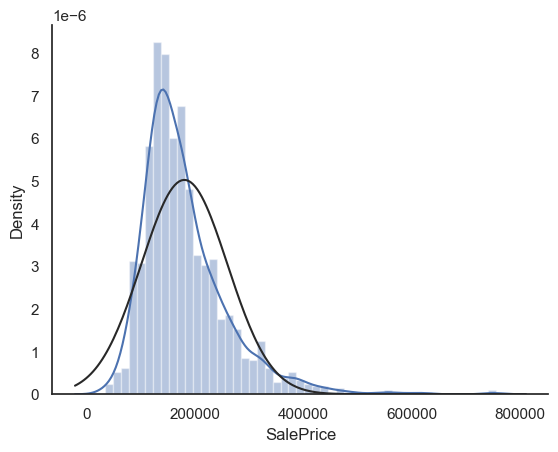

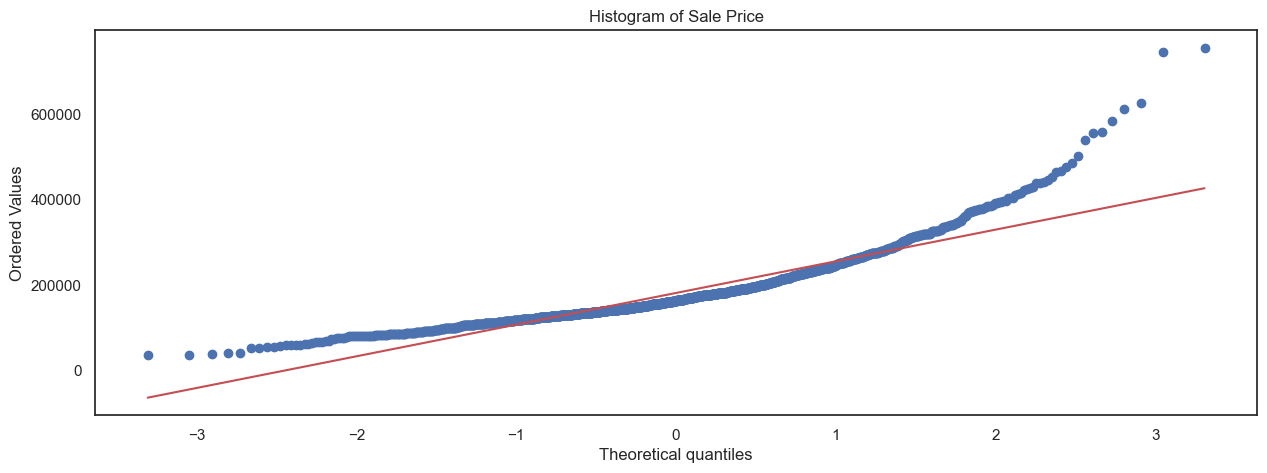

In [16]:
#histogram
sns.distplot(df_train['SalePrice'], fit=norm)
sns.despine(top=True, right=True)
plt.figure(figsize=(15, 5))
sns.set(style="white")
res = stats.probplot(df_train['SalePrice'], plot=plt)
plt.title('Histogram of Sale Price')
plt.show()

- Hình dạng gần giống với phân phối chuẩn

- Bị lệch phải

Nói chung về độ lệch, chúng ta có một số độ đo moment để thể hiện độ lệch:

In [238]:
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


- Skewness > 0 : positive skewness cho thấy biểu đồ lệch phải đúng với các nhận xét phía trên.

- Kurtosis > 3 : cho thấy số lượng outlier khá lớn, hay nói cách khác xác suất xuất hiện outlier khá cao.

Điều này cho thấy rằng SalePrice tuân theo phân phối Student, không phải phân phối chuẩn. Ta thực hiện thêm một số kiểm định thống kê để chắc chắn điều này.

In [17]:
from scipy.stats import shapiro 

In [18]:
shapiro(df_train.SalePrice)

ShapiroResult(statistic=0.869672954082489, pvalue=3.2072044604461286e-33)

Vì p-value < 0.05 nên ta có thể bác bỏ $H_0$, nghĩa là với mức ý nghĩa 95%, 

### Các biến khác

## Heatmap

Vẽ Heatmap là một cách làm tốt để xem correlation giữa các features với nhau. Từ heatmap ta sẽ có những bước đánh giá ban đầu cũng như target được một số các feature quan trọng cho mô hình. Nó cũng sẽ ảnh hưởng đến nhiều quyết định phía sau.

In [8]:
category_df = df_train.select_dtypes(include=['object'])
numeric_df = df_train.select_dtypes(include=['number'])

In [9]:
corrmat = numeric_df.corr()

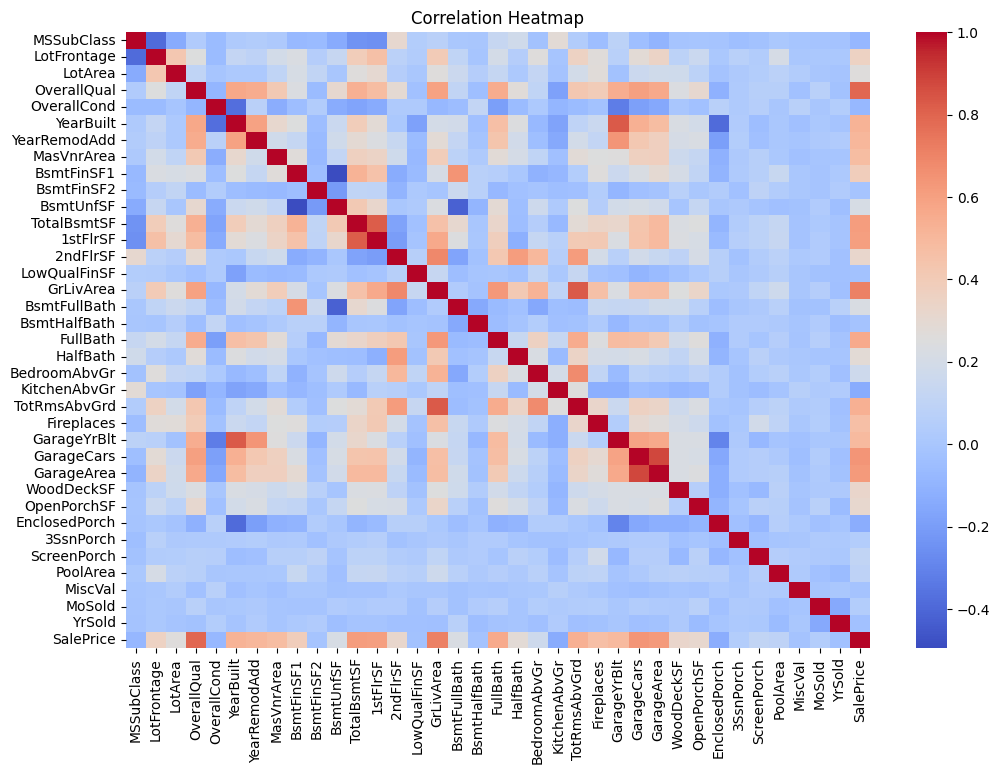

In [10]:
plt.figure(figsize=(12, 8))
sns.heatmap(corrmat, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Hãy để ý màu sắc của bar bên tay phải, màu càng đậm thì giá trị correlation càng cao, càng nhạt thì correlation càng thấp.

Lưu ý rằng khi nói correlation cao là nhắc đến strong correlation cả positive (1) và negative (-1), non-correlation mang giá trị 0. Vậy những biến strong correlation sẽ có màu đỏ đậm và xanh đậm.

Bài tập nhỏ:

- Hãy tìm ra những cột có correlation cao và thấp với SalePrice. 

- Trong những biến có correlation cao với SalePrice, những biến nào tiếp tục có mối tương quan cao với nhau?

Như đã nói ở trên, ta khoan hãy thực hiện Feature Selection ở bước này mã hãy tiếp tục thực hiện các bước pre-processing phía sau và dùng Heatmap correlation như 1 phần support.

In [239]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Có khá nhiều cột bị missing value, để thể hiện tốt hơn ta cần dùng các hàm khác bên ngoài

In [11]:
missing_count = df_train.isnull().sum().sort_values(ascending=False)
missing_percentage = (missing_count / len(df_train)) * 100

In [12]:
missing_df = pd.DataFrame(missing_percentage[missing_percentage > 0]).reset_index()
missing_df.columns = ['Column', 'MissingPercentage']

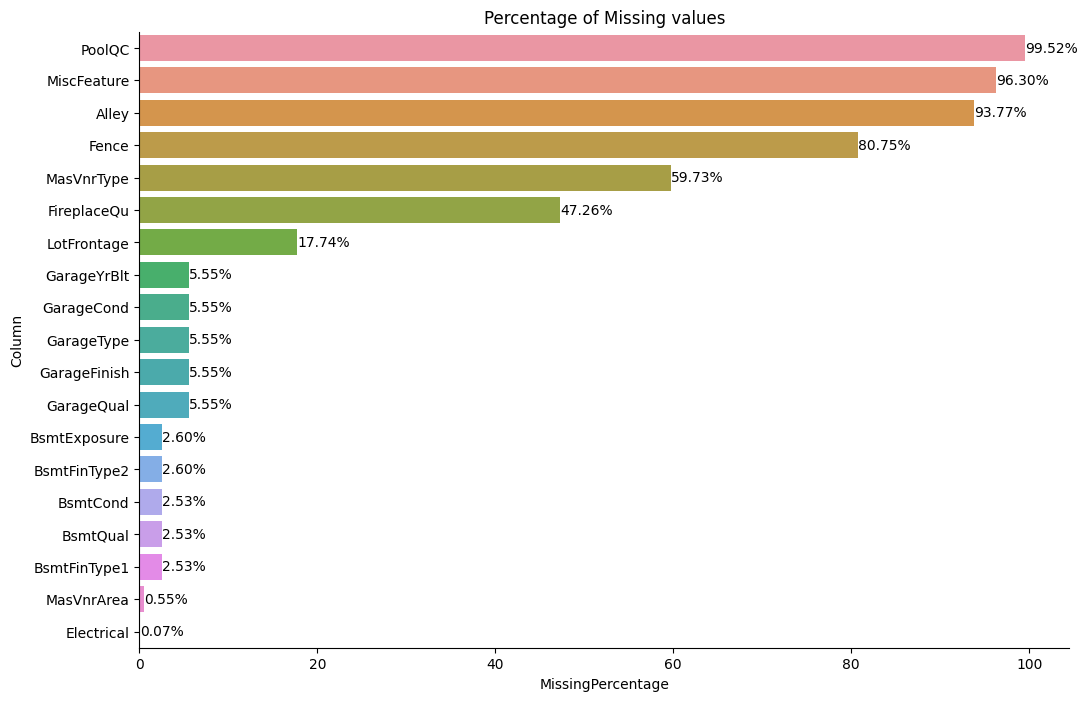

In [43]:
plt.figure(figsize=(12, 8))
sns.barplot(x='MissingPercentage', y='Column', data=missing_df)
for index, value in enumerate(missing_df['MissingPercentage']):
    plt.text(value, index, f'{value:.2f}%', color='black', va="center")
plt.title('Percentage of Missing values')
sns.despine(top=True, right=True)
plt.show()

Ta cần lưu ý một số điều quan trọng khi loại bỏ các cột missing data sau đây:

- THÔNG THƯỜNG nếu missing quá 70%-80% ta có thể loại bỏ cột đó.

Trong bài toán này, các cột missing value quá nhiều, tác giả ref nói rằng điều này cho thấy các biến này không quan trọng. Nghĩa là thông thường mọi người sẽ không đưa các biến nào vào xem xét để quyết định xem có nên mua một ngôi nhà hay không. Và chính chúng gây ra hiện tượng outliers (làm giá nhà tăng đột biến).

Chúng ta không làm bài toán detect outlier mà chúng ta chỉ muốn dự đoán pattern tổng quát. Do đó nên loại bỏ các biến này.

Tuy nhiên nếu bài toán đổi thành dự đoán chỉ số sức khỏe của một người để xem người đó có nguy cơ mắc bệnh ung thư hay không thì ta thật sự cần xem xét kỹ lưỡng khi loại bỏ các cột có missing value cao (chẳng hạn như bệnh nhân có hút thuốc lá chỉ chiếm 5% và những người này có nguy cơ ung thư cao).

Các biến liên quan đến Garage và Bsmt có cùng độ missing value. Do đó ta có thể nghi ngờ những records bị missing này giống nhau.

Thông thường theo hàng hoặc fill missing data sẽ hợp lý hơn. Tuy nhiên, tác giả lựa chọn bỏ các cột này, nguyên nhân đưa ra là:

- Dựa vào domain knowledge, tác giả nghĩ GarageCars mới ảnh hưởng lớn đến SalePrice, và các biến Garage còn lại có thể phụ thuộc tuyến tính (trùng lặp thông tin) với GarageCars nên sẽ loại bỏ các biến Garage khác. 

- Tương tự với Bsmt

- Cũng dựa vào Domain knowledge, "MasVnrArea" có strong correlation với 'YearBuilt' và 'OverallQual'. Cho dù ta có thực hiện fill missing data thì về sau khi kiểm tra độ phụ thuộc tuyến tính cũng sẽ phải loại bỏ 1 biến. Do đó ta cũng sẽ loại bỏ cột MasVnrArea.

In [13]:
df_train = df_train.drop(missing_df[missing_df['MissingPercentage'] > 0.5].Column, axis = 1)

- Và cuối cùng là cột Electrical, ta chỉ có 1 row bị missing data nên ta sẽ loại bỏ dòng này.

In [14]:
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)

Kiểm tra lại xem còn giá trị missing nào trong df không

In [15]:
df_train.isnull().sum().max()

0

## Outliers

In [16]:
def detect_and_calculate_outliers(df):
    summary_list = []
    
    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        outlier_threshold_low = Q1 - 1.5 * IQR
        outlier_threshold_high = Q3 + 1.5 * IQR
        extreme_outlier_threshold_low = Q1 - 3 * IQR
        extreme_outlier_threshold_high = Q3 + 3 * IQR

        outliers = df[(df[column] < outlier_threshold_low) | (df[column] > outlier_threshold_high)]
        extreme_outliers = df[(df[column] < extreme_outlier_threshold_low) | (df[column] > extreme_outlier_threshold_high)]

        outliers_percentage = len(outliers) / len(df) * 100
        extreme_outliers_percentage = len(extreme_outliers) / len(df) * 100

        summary_list.append({
            'Column': column,
            'Outliers_Percentage': outliers_percentage,
            'Extreme_Outliers_Percentage': extreme_outliers_percentage,
            'Outlier_threshold_low' : outlier_threshold_low,
            'Outlier_threshold_high' : outlier_threshold_high,
            'Extreme_outlier_threshold_low' : extreme_outlier_threshold_low,
            'Extreme_outlier_threshold_high' : extreme_outlier_threshold_high
        })
    
    outlier_summary = pd.DataFrame(summary_list)
    
    # Sort the summary by Outliers_Percentage and Extreme_Outliers_Percentage
    outlier_summary = outlier_summary.sort_values(by=['Outliers_Percentage', 'Extreme_Outliers_Percentage'], ascending=False)
    
    return outlier_summary

In [17]:
outlier_summary = detect_and_calculate_outliers(numeric_df)
outlier_summary

,Column,Outliers_Percentage,Extreme_Outliers_Percentage,Outlier_threshold_low,Outlier_threshold_high,Extreme_outlier_threshold_low,Extreme_outlier_threshold_high
29,EnclosedPorch,14.246575,14.246575,0.000,0.000,0.00,0.00
9,BsmtFinSF2,11.438356,11.438356,0.000,0.000,0.00,0.00
4,OverallCond,8.561644,0.068493,3.500,7.500,2.00,9.00
31,ScreenPorch,7.945205,7.945205,0.000,0.000,0.00,0.00
0,MSSubClass,7.054795,0.000000,-55.000,145.000,-130.00,220.00
7,MasVnrArea,6.575342,1.712329,-249.000,415.000,-498.00,664.00
1,LotFrontage,6.027397,0.821918,27.500,111.500,-4.00,143.00
17,BsmtHalfBath,5.616438,5.616438,0.000,0.000,0.00,0.00
28,OpenPorchSF,5.273973,1.232877,-102.000,170.000,-204.00,272.00
2,LotArea,4.726027,2.328767,1481.500,17673.500,-4590.50,23745.50


Trong reference xử lý khá qua loa và chỉ nhắc đến nên ở Level này ta chỉ dừng lại ở mức này. Sẽ cải thiện ở Level 5

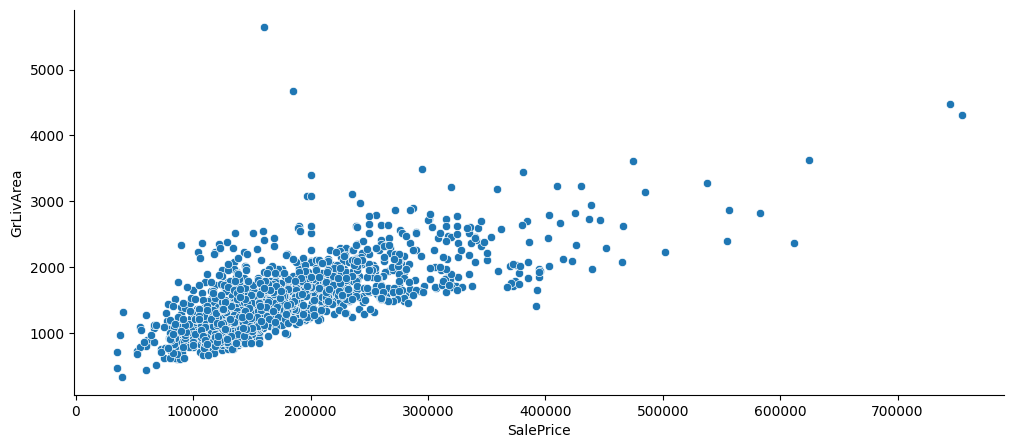

In [18]:
plt.figure(figsize=(12, 5))
sns.scatterplot(data = df_train, x = "SalePrice", y = "GrLivArea")
sns.despine(top=True, right=True)
plt.show()

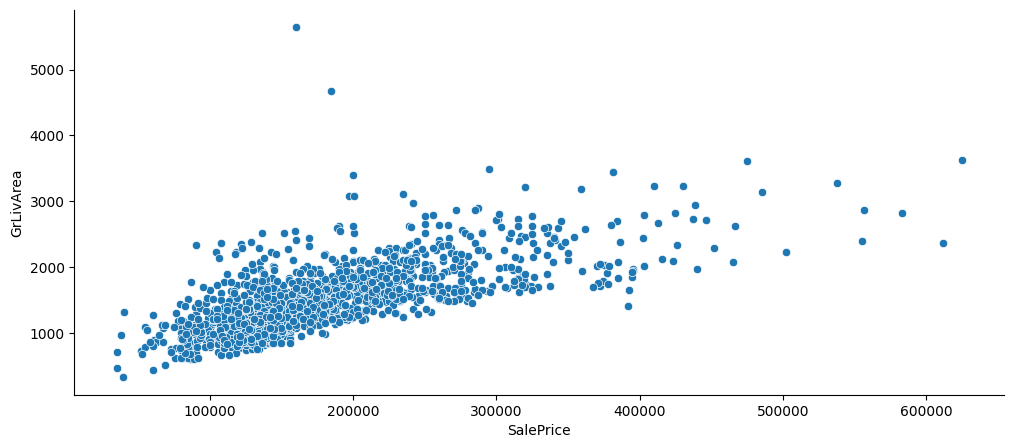

In [84]:
plt.figure(figsize=(12, 5))
sns.scatterplot(data = df_train, x = "SalePrice", y = "GrLivArea")
sns.despine(top=True, right=True)
plt.show()

## Advanced

## Normality

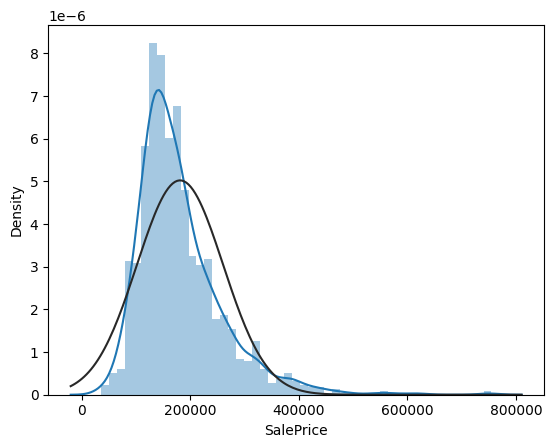

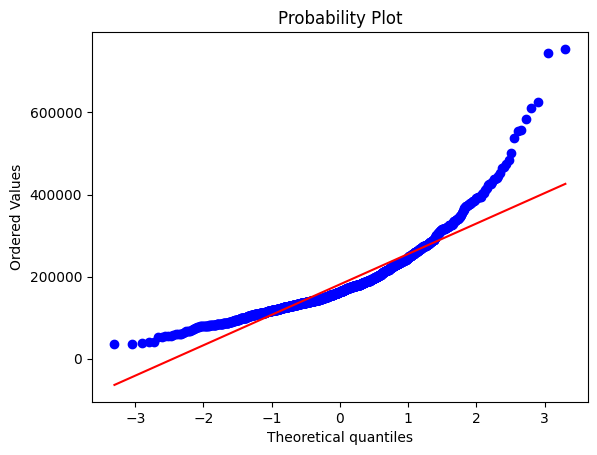

In [50]:
#histogram and normal probability plot
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

- Hình 1 cho biết: phân phối của SalePrice lệch so với phân phối chuẩn

- Hình 2 biểu đồ QQ-plot cho ta thấy những giá trị quan sát đa phần không nằm trên đường thẳng kì vọng của phân phối chuẩn do đó biến SalePrice không có tuân theo phân bố chuẩn.

### Log-transform

Một cách để giảm độ lệch các outlier đó là log_transform. Tận dụng tính chất của hàm log, giá trị càng lớn thì sẽ càng gần nhau (khác biệt với hàm bình phương).

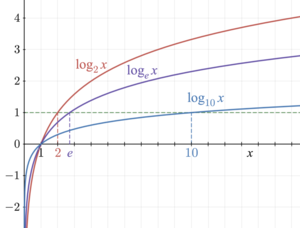

In [51]:
df_train['SalePrice'] = np.log(df_train['SalePrice'])

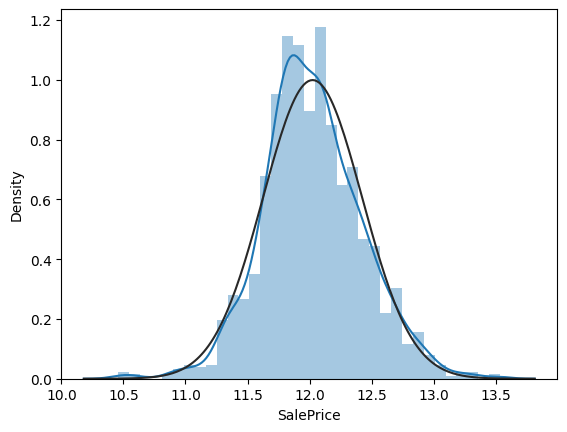

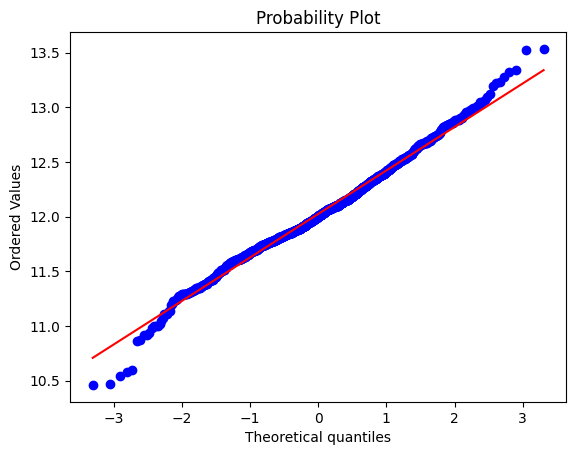

In [52]:
#transformed histogram and normal probability plot
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

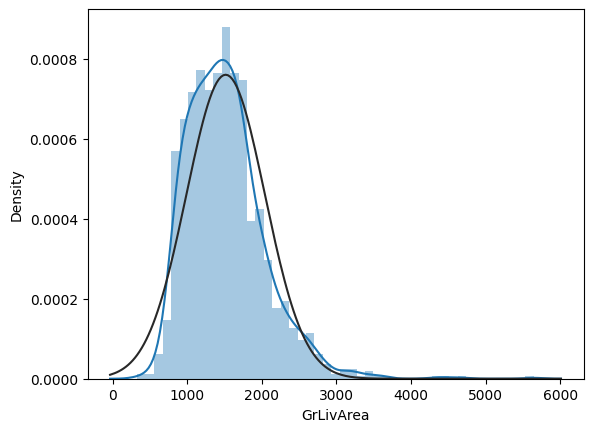

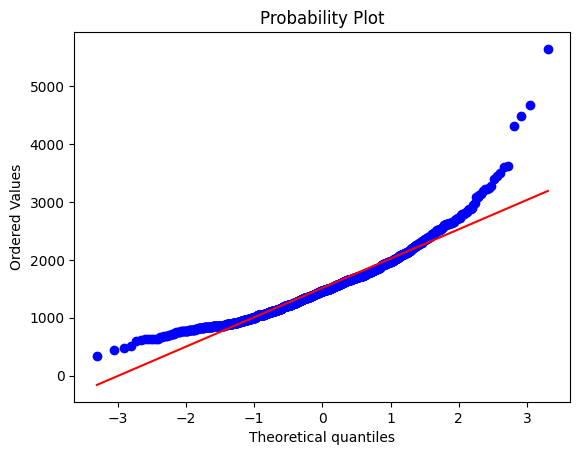

In [53]:
#histogram and normal probability plot
sns.distplot(df_train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot=plt)

In [54]:
#data transformation
df_train['GrLivArea'] = np.log(df_train['GrLivArea'])

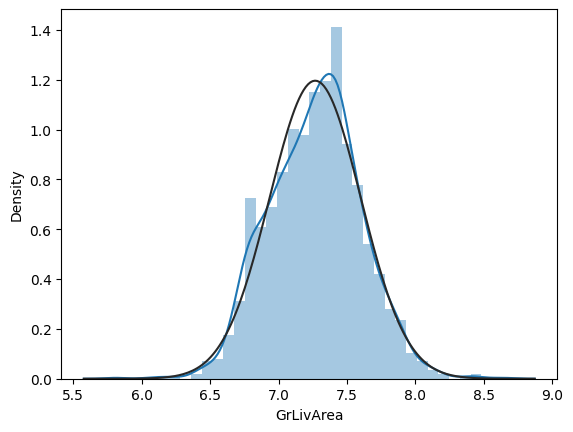

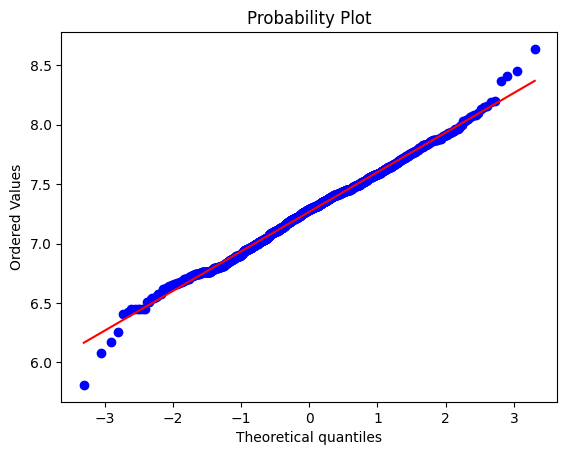

In [55]:
#transformed histogram and normal probability plot
sns.distplot(df_train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot=plt)

Feature engineering là quá trình tạo ra hoặc chuyển đổi các đặc trưng (features) từ dữ liệu đầu vào để cải thiện hiệu suất của mô hình máy học. Các kỹ thuật feature engineering có thể bao gồm `tạo ra các đặc trưng mới`, chuẩn hóa dữ liệu, xử lý dữ liệu thiếu, mã hóa biến phân loại, giảm chiều dữ liệu, và nhiều phương pháp khác để cải thiện độ chính xác và hiệu suất của mô hình.

Ta sẽ thực hiện biến đổi cột `TotalBsmtSF` từ numeric (diện tích basement) về binary (0/1 có basement/không có basement). Với những records có basement, ta sẽ thực hiện thay thế giá trị 1 bằng log-transform.

Tuy nhiên cách này hơi loằng quằng, nó chỉ hay ở chỗ đổi numeric sang binary thôi. Nếu ngay từ ban đầu chỉ muốn log-transform diện tích basement thì chỉ cần set điều kiện log những giá trị dương, và giá trị <= 0 thì trực tiếp gán = 0.

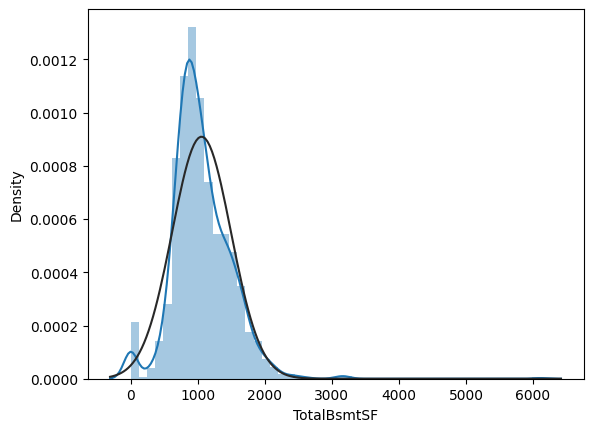

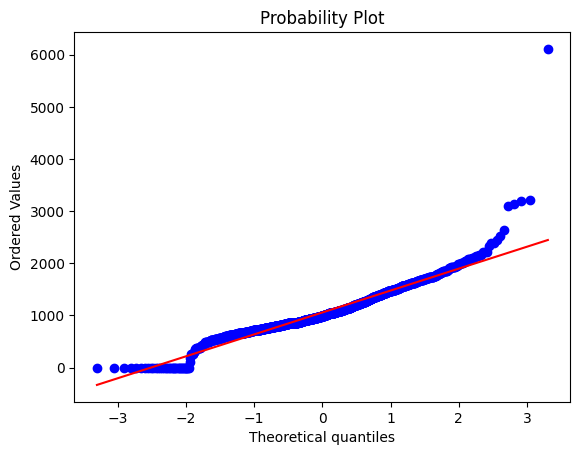

In [56]:
#histogram and normal probability plot
sns.distplot(df_train['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['TotalBsmtSF'], plot=plt)

In [57]:
df_train['HasBsmt'] = pd.Series(len(df_train['TotalBsmtSF']), index=df_train.index)
df_train['HasBsmt'] = 0 
df_train.loc[df_train['TotalBsmtSF']>0,'HasBsmt'] = 1

In [58]:
df_train.loc[df_train['HasBsmt']==1,'TotalBsmtSF'] = np.log(df_train['TotalBsmtSF'])

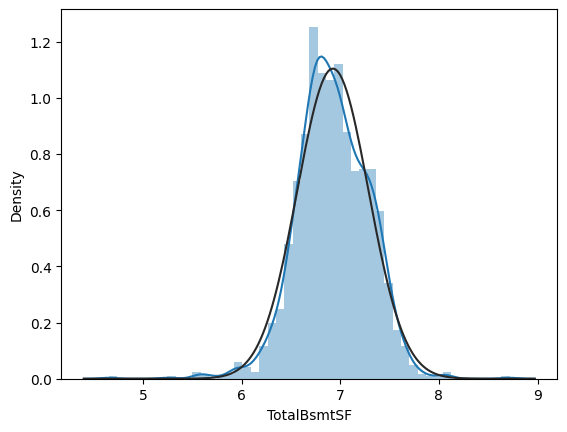

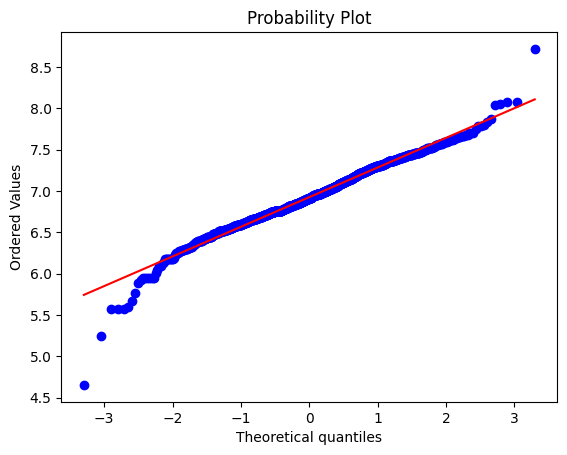

In [59]:
sns.distplot(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], plot=plt)

### Kiểm tra tính homoscedasticity, linear

Kiểm tra dựa vào biểu đồ, theo tác giả, bước thực hiện log-transform cũng đã giúp chúng ta giảm bớt việc phương sai giữa các biến không đồng nhất homoscedasticity. Giúp đưa phương sai của các biến về là hằng số.

Ngoài ra việc kiểm tra xem các features có là linear hay không đã được thực hiện ngay từ pairplot ở bước đầu.

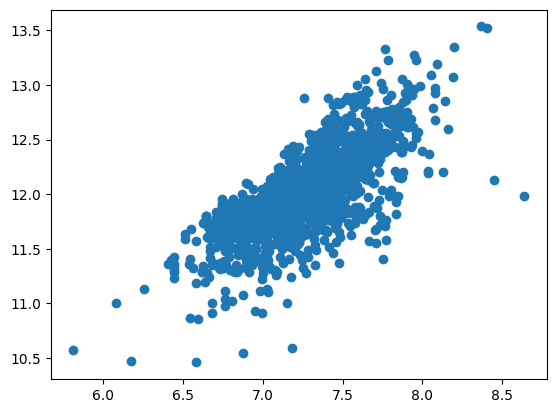

In [60]:
plt.scatter(df_train['GrLivArea'], df_train['SalePrice']);

Tác giả bỏ qua việc kiểm tra correlation giữa các feature residuals.

## Dummies

Chuyển từ Label Encoder -> dummies. Tuy nhiên cần cẩn thận dummies trap. Nghĩa là sau bước này cần thực hiện Feature Selection thêm 1 lần nữa.

In [61]:
#convert categorical variable into dummy
df_train = pd.get_dummies(df_train)

In [62]:
df_train

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,False,False,False,True,False,False,False,False,True,False
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,False,False,False,True,False,False,False,False,True,False
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,False,False,False,True,False,False,False,False,True,False
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,False,False,False,True,True,False,False,False,False,False
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,False,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,62.0,7917,6,5,1999,2000,0.0,0,...,False,False,False,True,False,False,False,False,True,False
1456,1457,20,85.0,13175,6,6,1978,1988,119.0,790,...,False,False,False,True,False,False,False,False,True,False
1457,1458,70,66.0,9042,7,9,1941,2006,0.0,275,...,False,False,False,True,False,False,False,False,True,False
1458,1459,20,68.0,9717,5,6,1950,1996,0.0,49,...,False,False,False,True,False,False,False,False,True,False
